In [86]:
import pandas as pd
import numpy as np
from src.one_hot_encoding import encode_categorical_variable, join_to_df
from src.classification_class import CustomClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split

In [2]:
import shap

/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:
def string_to_list(input_string):
    output_list = input_string.split(",")
    output_list = [elem.strip() for elem in output_list]
    return output_list

def list_to_string(input_list):
    output_string = ', '.join(input_list)
    return output_string


def remove_consecutive_same_string(input_list):
    list_length = len(input_list)
    clean_list = []
    clean_list.append(input_list[0])
    for i in range(1, list_length):
        # print(i, clean_list, input_list[i])
        if (input_list[i] != input_list[i - 1]):
            clean_list.append(input_list[i])
    return clean_list

# Data Investigation

In [4]:
property_events = pd.read_csv("data/prop_events_for_test.csv")
print(property_events.shape)
properties = pd.read_csv("data/property_for_test.csv")
print(properties.shape)

(18922, 3)
(15101, 35)


In [5]:
# Check the ids
if properties['prop_id'].value_counts().max() > 1:
    print("There are duplicates in the propery id")
print(f"There are {properties['prop_id'].shape[0]} unique properties")
# Check the properties that we have historical data
properties_with_historical_data = properties.merge(property_events.drop_duplicates(subset = ['prop_id']), on = 'prop_id')['prop_id']
print(f"There are {properties_with_historical_data.shape[0]} properties with historical data")

There are 15101 unique properties
There are 6514 properties with historical data


1995-01-06 2018-07-07


<AxesSubplot: title={'center': 'Historic data points per property'}, xlabel='frequency'>

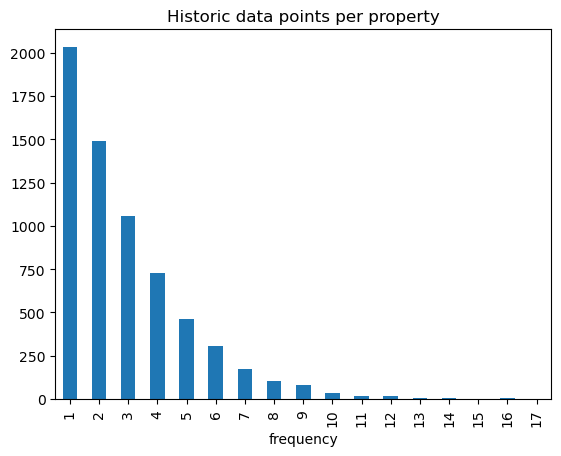

In [6]:
# Understand the historical data
property_events['day'] = property_events['date'].apply(lambda x : x [0:10])
print(property_events['day'].min(), property_events['day'].max())
# Property events frequency
property_events_freq = property_events['prop_id'].value_counts().reset_index().rename(columns = {'index': 'prop_id', 'prop_id' : 'frequency'})
property_events_freq.groupby(['frequency'])['prop_id'].count().plot.bar(title= "Historic data points per property")

In [7]:
# Histogram of type of events
property_events['type'].value_counts()#.plot.bar()

survey                13063
sale                   1641
l_rent                 1408
l_rented                968
l_for_sale              885
l_sold                  767
l_sale_under_offer      115
l_rent_under_offer       75
Name: type, dtype: int64

In [8]:

series_of_actions = property_events.sort_values('date').groupby(['prop_id']).agg({'type': ', '.join}).reset_index().rename(columns = {'type' : 'series_of_actions'})
series_of_actions['series_of_actions'].value_counts().to_frame()
series_of_actions["non_consequtive"] = series_of_actions['series_of_actions'].apply(lambda x : list_to_string(remove_consecutive_same_string(string_to_list(x))) )
series_of_actions["non_consequtive"] .value_counts().head(20)

survey                                        3857
survey, sale                                   562
sale                                           178
survey, l_rent, l_rented                       152
survey, l_rent                                 148
l_rent                                         147
survey, l_for_sale, l_sold, sale               109
l_rent, l_rented                               102
survey, l_for_sale, l_sold, survey, sale        60
l_for_sale, l_sold, sale                        48
survey, l_rented                                45
survey, sale, survey                            45
survey, l_for_sale, l_sold                      44
l_rented                                        37
l_for_sale, l_sold                              36
survey, l_for_sale                              36
survey, l_for_sale, sale                        32
survey, l_rent, l_rented, l_rent, l_rented      31
l_for_sale                                      30
survey, l_sold, sale           

## Properties

In [9]:
properties.groupby(['post_town', 'postcode_sector'])['prop_id'].count()

post_town  postcode_sector
BRISTOL    BS6 5              5404
           BS6 6              5717
           BS6 7              3980
Name: prop_id, dtype: int64

<AxesSubplot: ylabel='Frequency'>

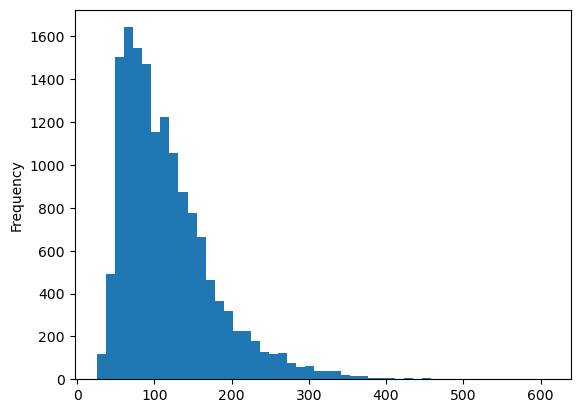

In [10]:
properties['floor_area'].plot.hist(bins=50)

# Rules Assignment

In [11]:
series_of_actions_freq = series_of_actions["non_consequtive"] .value_counts().reset_index()

In [12]:
decisive_events = ['sale', 'l_rented', 'l_sold']

# latest_event 
latest_event = property_events.groupby(['prop_id'])['day'].max().reset_index()
latest_event = latest_event.merge(property_events, on = ['prop_id', 'day'])[['prop_id', 'day', 'type']]
labeled_data = latest_event[latest_event['type'].isin(decisive_events)]
labeled_data['Label'] = labeled_data['type'].apply(lambda x : 'Inhabitants' if x in ['sale', 'l_sold'] else 'Renters')
labeled_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,prop_id,day,type,Label
0,129114,2016-02-16,sale,Inhabitants
2,129451,2018-05-10,l_rented,Renters
9,129853,2014-10-22,l_rented,Renters
12,129937,2018-04-20,l_sold,Inhabitants
17,130114,2018-03-08,l_rented,Renters
...,...,...,...,...
6507,456054,2017-05-24,sale,Inhabitants
6508,456386,2016-03-11,sale,Inhabitants
6509,456969,2017-01-06,sale,Inhabitants
6510,457708,2017-07-13,sale,Inhabitants


# Classification

In [154]:
training_features = ['x_coordinate', 'y_coordinate', 'bathrooms','bedrooms',
 'floor_area', 'year_built', 'property_value', 'property_rental_value']
to_encode = ['postcode_sector', 'property_type', 'ht_property_type', 'tenure'] #'property_style'


In [155]:
all_encoded_data = pd.DataFrame()
for col in to_encode:
    encoded_data = encode_categorical_variable(input_df=properties, col_name = col, id_col = 'prop_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

all_encoded_data    

,postcode_sector_BS6 5,postcode_sector_BS6 6,postcode_sector_BS6 7,property_type_Bungalow/Chalet,property_type_Flat/Maisonette,property_type_House,ht_property_type_All,ht_property_type_Detached,ht_property_type_Flat/Maisonette,ht_property_type_Semi-Detached,ht_property_type_Terraced,tenure_Feudal,tenure_Freehold,tenure_Leasehold,tenure_Shared
prop_id,,,,,,,,,,,,,,,
147676,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
152958,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
154711,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
155062,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
158773,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163710,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
143377,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
388773,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [156]:
classification_data = (properties[['prop_id'] + training_features].set_index('prop_id').join(all_encoded_data).reset_index())
classification_data = classification_data.merge(labeled_data[['prop_id', 'Label']], on = 'prop_id')
print(classification_data.shape)
classification_data = classification_data.dropna()
print(classification_data.shape)

(1965, 25)
(1952, 25)


In [157]:
label = ['Label']
training_columns = [col for col in classification_data.columns if col not in ['prop_id', 'Label']]
X = classification_data[training_columns + ['prop_id']].set_index('prop_id')
y = classification_data[label + ['prop_id']].set_index('prop_id')
from sklearn.model_selection import train_test_split
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(1171, 23) (1171, 1) (390, 23) (390, 1) (391, 23) (391, 1)


In [160]:
y.value_counts()['Inhabitants']/y.shape[0]

0.7387295081967213

In [161]:
import src.classification_class
import importlib
importlib.reload(src.classification_class)
from src.classification_class import CustomClassifier

In [162]:

# Random Forest
print(" --------------------- RF --------------------")
classifiers_outputs = {}
rf = CustomClassifier("RF")
rf.set_train_and_test_data(X_train, X_val, y_train, y_val)
rf.fit_model()
rf.estimate_accuracy()
rf.estimate_precision()
rf.estimate_f1_score()
rf.estimate_training_accuracy()

# Logistic Regression
print(" --------------------- LR --------------------")
lr = CustomClassifier("LR")
lr.set_train_and_test_data(X_train, X_val, y_train, y_val)
lr.fit_model()

lr.estimate_accuracy()
lr.estimate_precision()
lr.estimate_f1_score()
lr.estimate_training_accuracy()

# XGBoost
print(" --------------------- XGB --------------------")
xgb = CustomClassifier("XGBoost")
xgb.set_train_and_test_data(X_train, X_val, y_train, y_val)
xgb.fit_model()
xgb.estimate_accuracy()
xgb.estimate_precision()
xgb.estimate_f1_score()
xgb.estimate_training_accuracy()

 --------------------- RF --------------------
RF
Accuracy of RF classifier on test set: 0.7846
Precision of RF classifier on test set: 0.7691
F1-score (unweighted) of RF classifier on test set: 0.6728
F1-score (weigthed) of RF classifier on test set: 0.7621

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy of RF classifier on training set: 0.9991
 --------------------- LR --------------------
LR
Accuracy of LR classifier on test set: 0.7256
Precision of LR classifier on test set: 0.6142
F1-score (unweighted) of LR classifier on test set: 0.4380
F1-score (weigthed) of LR classifier on test set: 0.6257
Accuracy of LR classifier on training set: 0.7387
 --------------------- XGB --------------------
XGBoost
[14:46:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Accuracy of XGBoost classifier on test set: 0.7513
Precision of XGBoost classifier on test set: 0.7276
F1-score (unweighted) of XGBoost classifier on test set: 0.6336
F1-score (weigthed) of XGBoost classifier on test set: 0.7305
Accuracy of XGBoost classifier on training set: 1.0000


1.0

In [163]:
# Results formatted
classifiers_list = [rf, lr, xgb]
classifiers_outputs = pd.DataFrame(columns = ["RF", "LR", "XGBoost"], index = ["Accuracy" , "Precision", "F1_score unweighted", "F1_score weighted"])
for classifier in classifiers_list:
    classifiers_outputs.loc['Training Accuracy', classifier.model] = round(classifier.training_accuracy, 3)
    classifiers_outputs.loc['Accuracy', classifier.model] = round(classifier.accuracy, 3)
    classifiers_outputs.loc['Precision', classifier.model] = round(classifier.precision, 3)
    classifiers_outputs.loc['F1_score unweighted', classifier.model] = round(classifier.f1_score_macro, 3)
    classifiers_outputs.loc['F1_score weighted', classifier.model] = round(classifier.f1_score_weighted, 3)

classifiers_outputs.T#.to_clipboard()

,Accuracy,Precision,F1_score unweighted,F1_score weighted,Training Accuracy
RF,0.785,0.769,0.673,0.762,0.999
LR,0.726,0.614,0.438,0.626,0.739
XGBoost,0.751,0.728,0.634,0.731,1.0


# Check for statistical significance
H0: Random Forest and XGBoost has the same accuracy performance <br>
H1: Random Forest performs better than XGBoost

In [164]:
import math
import scipy.stats as st

In [165]:
# Two proportion z-test
p1  = rf.accuracy
p2 = xgb.accuracy
n = X_val.shape[0]
x1 = round(p1 * n)
x2 = round(p2 * n)
p = (x1+x2)/(2*n)
print(p1, p2, n, x1, x2, p)
Z = (p1 - p2)/(math.sqrt((2*p*(1-p)/n)))
print(Z)

print(f"With confidence of {round(st.norm.cdf(Z)*100, 1)} % Random Forest performs better than XGBoost")

0.7846 0.7513 390 306 293 0.767948717948718
1.1015480429909796
With confidence of 86.5 % Random Forest performs better than XGBoost


In [166]:
# rf_explainer = shap.Explainer(rf.classifier, X_train)
# shap_values_rf = rf_explainer(X_test)


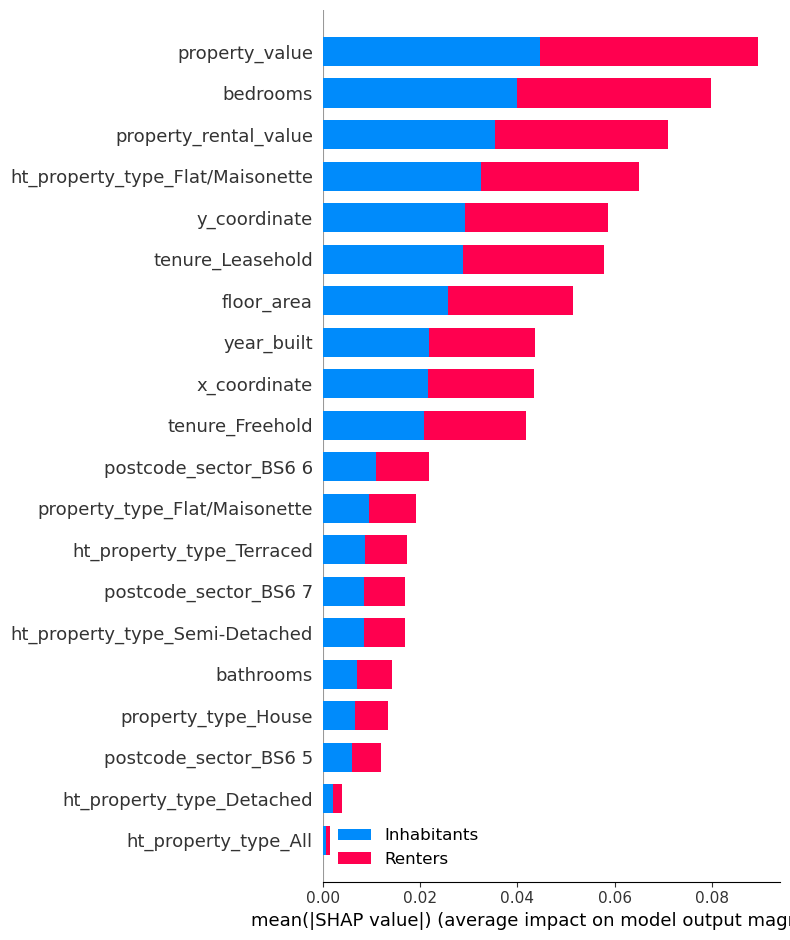

In [167]:
explainer = shap.TreeExplainer(rf.classifier)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= list(y['Label'].drop_duplicates()), feature_names = X.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


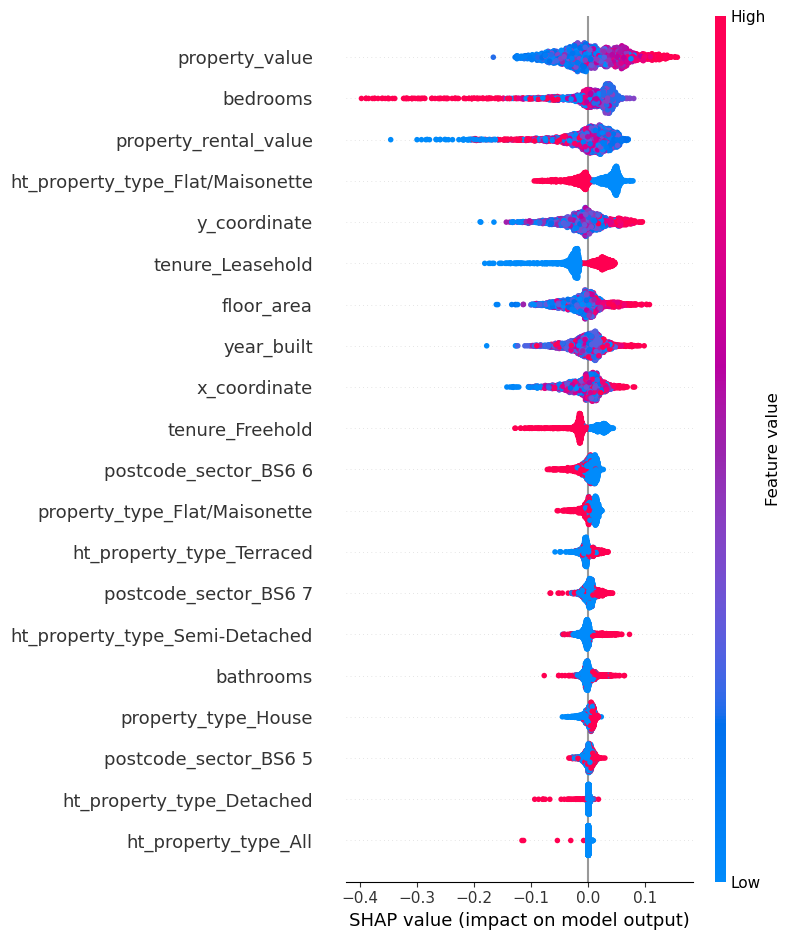

In [168]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns)

In [169]:
rf.estimate_feature_importance()

,Feature,Significance
7,property_rental_value,0.150716
6,property_value,0.130876
1,y_coordinate,0.122811
4,floor_area,0.118552
0,x_coordinate,0.117809
5,year_built,0.105412
3,bedrooms,0.100888
21,tenure_Leasehold,0.023565
2,bathrooms,0.019948
20,tenure_Freehold,0.018845


In [71]:
# How to deal with imbalanced dataset?

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [82]:
X_train.shape

(1171, 23)

# Model Optimisation

In [170]:
import numpy as np
np.sum(split_index)

-1171

In [144]:
split_index = [-1 if x in rf.X_train.index else 0 for x in X_train.append(X_val).index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
print(len(split_index))


parameters = {
    'max_depth': [5, 10, 50, 100, 500, None],#range (3, 10, 50),
    'n_estimators': [50, 100, 200, 500, 1000],#range(50, 200, 500),
    'min_samples_leaf' : [3, 5, 10, 50],
    'max_features' : ['auto', 0.4 ]
}

random_search = RandomizedSearchCV(
    estimator=rf.classifier,
    param_distributions =parameters,
    n_iter= 50,
    scoring = 'accuracy',
    n_jobs = 1,
    cv = pds,
    verbose=10,
    random_state=7
)

1561


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
%%time
random_search.fit(X_train.append(X_val), y_train.append(y_val))

In [146]:
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 0.4, 'max_depth': None, 'bootstrap': False}
0.8076923076923077


In [136]:
random_search.best_estimator_

RandomForestClassifier(max_depth=10, max_features=0.4, min_samples_leaf=5,
                       random_state=7)

In [179]:
# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_val,random_search.predict(X_val)))
# print(accuracy_score(y_train,random_search.predict(X_train)))
# print(accuracy_score(y_test,random_search.predict(X_test)))
# print(random_search.best_estimator_.score(X_val, y_val))
# print(random_search.best_estimator_.score(X_test, y_test))

In [151]:
random_search.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 10,
 'max_features': 0.4,
 'max_depth': None,
 'bootstrap': False}

In [171]:
final_classifier = CustomClassifier("RF")
final_classifier.set_train_and_test_data(X_train.append(X_val), X_test, y_train.append(y_val), y_test)
# final_classifier.set_train_and_test_data(X_train, X_val, y_train, y_val)
final_classifier.fit_model(n_estimators = 100, min_samples_leaf = 5, max_features = 0.4, max_depth = 10) # with these parameters I get the same test output with a lighter model
print(final_classifier.classifier)
final_classifier.estimate_accuracy()
final_classifier.estimate_precision()
final_classifier.estimate_f1_score()
final_classifier.estimate_training_accuracy()
print(final_classifier.X_train.shape, final_classifier.y_train.shape, final_classifier.X_test.shape, final_classifier.y_test.shape)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RF
RandomForestClassifier(max_depth=10, max_features=0.4, min_samples_leaf=5,
                       random_state=7)
Accuracy of RF classifier on test set: 0.7928
Precision of RF classifier on test set: 0.7875
F1-score (unweighted) of RF classifier on test set: 0.6456
F1-score (weigthed) of RF classifier on test set: 0.7560
Accuracy of RF classifier on training set: 0.8507
(1561, 23) (1561, 1) (391, 23) (391, 1)


In [172]:
X

,x_coordinate,y_coordinate,bathrooms,bedrooms,floor_area,year_built,property_value,property_rental_value,postcode_sector_BS6 5,postcode_sector_BS6 6,...,property_type_House,ht_property_type_All,ht_property_type_Detached,ht_property_type_Flat/Maisonette,ht_property_type_Semi-Detached,ht_property_type_Terraced,tenure_Feudal,tenure_Freehold,tenure_Leasehold,tenure_Shared
prop_id,,,,,,,,,,,,,,,,,,,,,
162351,359182.00,174475.00,1.0,2.0,43.0,1984.0,340297.44,4437.358,1,0,...,0,0,0,0,0,1,0,1,0,0
131516,358524.00,176377.00,1.0,5.0,188.0,1932.0,643846.00,1999.000,0,0,...,1,0,0,0,1,0,0,1,0,0
131639,358656.00,176325.00,1.0,2.0,64.0,1960.0,241599.00,942.413,0,0,...,0,0,0,1,0,0,0,0,1,0
136345,358303.00,176058.00,1.0,3.0,135.0,1933.0,579616.00,1074.890,0,0,...,1,0,0,0,1,0,0,1,0,0
138587,358111.00,175938.00,1.0,3.0,164.0,1890.0,625991.00,1457.000,0,0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443931,357532.13,175822.86,1.0,1.0,53.0,2013.0,269789.00,1002.400,0,0,...,0,0,0,1,0,0,0,0,1,0
447280,359328.18,174321.58,1.0,2.0,92.0,2014.0,397496.00,1278.000,1,0,...,1,0,0,0,0,1,0,1,0,0
447448,358273.78,174452.09,2.0,5.0,133.0,1900.0,390395.00,1860.340,0,1,...,0,0,0,1,0,0,0,0,1,0


In [174]:
# Predict on Remaining data
unlabeled_data = properties[~properties['prop_id'].isin(X.reset_index()['prop_id'])]
print(unlabeled_data.shape)

(13149, 35)


In [182]:
training_features = ['x_coordinate', 'y_coordinate', 'bathrooms','bedrooms',
 'floor_area', 'year_built', 'property_value', 'property_rental_value']
to_encode = ['postcode_sector', 'property_type', 'ht_property_type', 'tenure'] #'property_style'

all_encoded_data = pd.DataFrame()
for col in to_encode:
    encoded_data = encode_categorical_variable(input_df=unlabeled_data, col_name = col, id_col = 'prop_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

unlabeled_data_numerical = (unlabeled_data[['prop_id'] + training_features].set_index('prop_id').join(all_encoded_data).reset_index()).set_index('prop_id')
unlabeled_data_numerical = unlabeled_data_numerical.dropna()
print(unlabeled_data_numerical.shape)

(13096, 23)


In [187]:
unlabeled_data_numerical['predictions'] = final_classifier.classifier.predict(unlabeled_data_numerical) # unlabeled_data_numerical


In [188]:
unlabeled_data_numerical

,x_coordinate,y_coordinate,bathrooms,bedrooms,floor_area,year_built,property_value,property_rental_value,postcode_sector_BS6 5,postcode_sector_BS6 6,...,ht_property_type_All,ht_property_type_Detached,ht_property_type_Flat/Maisonette,ht_property_type_Semi-Detached,ht_property_type_Terraced,tenure_Feudal,tenure_Freehold,tenure_Leasehold,tenure_Shared,predictions
prop_id,,,,,,,,,,,,,,,,,,,,,
147676,357605.0,175370.0,1.0,2.0,75.0,1926.0,378103.60,4364.6704,0,0,...,0,0,1,0,0,0,0,1,0,Inhabitants
152958,359244.0,175113.0,1.0,2.0,77.0,1932.0,377139.25,4511.5044,1,0,...,0,0,1,0,0,0,0,1,0,Inhabitants
154711,357885.0,174968.0,1.0,1.0,52.0,1925.0,322239.60,4114.7810,0,1,...,0,0,1,0,0,0,0,1,0,Inhabitants
155062,358435.0,174998.0,1.0,1.0,172.0,1933.0,367524.94,3735.5132,0,0,...,0,0,1,0,0,0,1,0,0,Renters
158773,359518.0,174770.0,1.0,2.0,87.0,1969.0,313844.66,4306.3100,1,0,...,0,1,0,0,0,0,1,0,0,Inhabitants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163710,357957.0,174490.0,1.0,2.0,71.0,1927.0,331794.03,4112.6990,0,1,...,0,0,1,0,0,0,1,0,0,Renters
143377,357624.0,175707.0,1.0,1.0,61.0,1960.0,326845.88,4093.6616,0,0,...,0,0,1,0,0,0,0,1,0,Inhabitants
388773,358976.0,174622.0,1.0,1.0,57.0,1905.0,277276.56,3814.5576,1,0,...,0,0,1,0,0,0,0,1,0,Inhabitants
